In [6]:
import socket
import sys
import cv2
import numpy as np
import struct
import argparse
import math
import random
import json
import datetime
from collections import namedtuple

import torch
import torch.optim as optim

import DQN
from Enet import ENet
import utils_socket
import utils_obs
from os import listdir


In [2]:
import importlib
importlib.reload(utils_obs)
importlib.reload(DQN)

<module 'DQN' from '/Users/karl/Documents/Notebooks/RobotRL/DQN.py'>

In [3]:
class Args:
    model_direc = "./Model/"
    interruption_direc = "./Interruption/"
    obs_mode = 1  #0: raw image,  1: processed_img,  2: segmentation image
    total_steps = 10000
    lr = 0.005
    batch_size = 32
    grad_clamp = 1
    EPS_START = 0.9
    EPS_END = 0.05
    EPS_DECAY = 50
args = Args()

def send_action(step, action, socket):
    socket.send(struct.pack(">i", step))
    socket.send(struct.pack(">i", int(1500+50*(action-3))))       

def select_action(steps_done, state, args, model):
    sample = random.random()
    eps_threshold = args.EPS_END + (args.EPS_START - args.EPS_END) * math.exp(-1. * steps_done / args.EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            state = torch.from_numpy(state).float().unsqueeze(0)
            return model(state).max(1)[1][0].item()
    else:
        return random.randrange(7)

def get_model_obs(img, processed_img, mode):
    if mode == 0:
        obs = cv2.resize(img, (80,60))/255
        return np.transpose(obs, (2,0,1))  # 3x60x80
    else:
        obs = (cv2.resize(processed_img, (80,60))/255/2+0.25)
        return np.stack([obs, obs, obs], axis=0)  # 3x60x80    

In [4]:
# start
interrupted = False
steps_done = 0
steps_todo = 10000

In [5]:
# initializations
# helpers 
img_processor = utils_obs.ImgProcessor()
rewarder = utils_obs.Rewarder()
imgs_log = {}
sonars_log = {}
Transition = namedtuple('Transition', 'state action next_state reward')

# memory
memory = DQN.ReplayMemory(1000)
# model
policy_dqn = DQN.DQN()
with torch.no_grad():
    target_dqn = DQN.DQN()
    target_dqn.load_state_dict(policy_dqn.state_dict())
# agent
agent = DQN.Agent(policy_dqn, target_dqn, args.lr, args.batch_size, args.grad_clamp)
# rewards
rewards = {}

# # recover from interruption
# if interrupted:
#     policy_dqn.load_state_dict(torch.load(args.interruption_direc+str(step)+"policy.model"))
#     target_dqn.load_state_dict(torch.load(args.interruption_direc+str(step)+"target.model"))
#     memory = torch.load(args.interruption_direc+str(step)+".memory")

In [6]:
# connect to agent
ip_port = ('192.168.43.1', 21111)
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect(ip_port)
# send password
string = "111"
s.send(string.encode())
# send speed and step
s.send(struct.pack(">I", 1700))
s.send(struct.pack(">I", steps_done))
s.send(struct.pack(">I", 1600))  # tilt
s.send(struct.pack(">I", 1000))  # period

4

In [101]:
########### Train ##############

# reset
sonars, img = utils_socket.get_obs(s)  #img: BGR
processed_img = img_processor.process_img(img)
obs = get_model_obs(img, processed_img, args.obs_mode)
imgs_log[steps_done] = img
sonars_log[steps_done] = sonars
# steps_todo = 3
print("start")
while(steps_done < steps_todo):
    # select actions
    action = select_action(steps_done, obs, args, policy_dqn)
    send_action(steps_done, action, s)
 
    # delay training to save time
    agent.update(memory)
    
    # get next state and reward
    sonars, img = utils_socket.get_obs(s)
    processed_img = img_processor.process_img(img)
    obs_next = get_model_obs(img, processed_img, args.obs_mode)
    reward = rewarder.reward(processed_img, sonars)
    rewards[steps_done] = reward
    done = True if reward < 0 else False
    if done:
        obs_next = None
    
    steps_done += 1

    # save transition to memory
    memory.push(obs, action, obs_next, reward)
    

    
    # save data
    if reward < 0:
        imgs_log[-steps_done] = img
        sonars_log[-steps_done] = sonars
    else:
        imgs_log[steps_done] = img
        sonars_log[steps_done] = sonars
        
    if(steps_done % 50 == 0):
        # save experiences
        saver = utils_obs.Saver("./Record/"+str(steps_done)+".txt", imgs_log.copy(), sonars_log.copy())
        saver.start()
        imgs_log.clear()
        sonars_log.clear()
        # save model
        torch.save(policy_dqn.state_dict(), "./Model/"+str(steps_done)+".pt")
        # synchronize
        target_dqn.load_state_dict(policy_dqn.state_dict())
    
    #stop to reset the robot
    if done:
        print(steps_done)
        break


start
212


In [100]:
send_action(-1, 3, s)  #ask robot to resend image
with open("./Record/reward.txt", "w") as f:
    json.dump(rewards, f)


In [66]:
steps_done = 10

In [145]:
# Test rewarder
importlib.reload(utils_obs)
rewarder = utils_obs.Rewarder()
img = cv2.imread("/Users/karl/Desktop/Pictures/1562621876378.jpg",cv2.IMREAD_UNCHANGED)
processed_img = img_processor.process_img(img)
reward = rewarder.reward(processed_img, (10,10,10))
print(reward)
show([img, processed_img])

354195
0.5


In [76]:
# Test actions
sonars, img = utils_socket.get_obs(s)  #img: BGR
processed_img = img_processor.process_img(img)
obs = get_model_obs(img, processed_img, args.obs_mode)
imgs_log[steps_done] = img
sonars_log[steps_done] = sonars

In [37]:
s.send(struct.pack(">I", steps_done))
steps_done += 1
s.send(struct.pack(">I", 1600))

4

In [103]:
def show(imgs):
    cv2.startWindowThread()
    for i in range(len(imgs)):
        cv2.imshow('image'+str(i),imgs[i])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [104]:
show([img])

In [105]:
show([processed_img])

In [65]:
rewards

{0: 0.5,
 1: -1.0,
 2: 0.5,
 3: -1.0,
 4: 0.5,
 5: -1.0,
 6: 0.5,
 7: 0.5,
 8: 0.5,
 9: -1.0,
 10: 0.5}

In [71]:
sonars, img = utils_socket.get_obs(s)  #img: BGR
processed_img = img_processor.process_img(img)
obs = get_model_obs(img, processed_img, args.obs_mode)
imgs_log[steps_done] = img
sonars_log[steps_done] = sonars

In [154]:
model_path = "/Users/karl/Documents/Notebooks/RobotRL/park_save/park_model"
ckp = torch.load(model_path, map_location='cpu')
enet = ENet(2)
enet.eval()
enet.load_state_dict(ckp['state_dict'])
torch.save(enet.state_dict(), "/Users/karl/Documents/Notebooks/RobotRL/Model/seg_model")

In [173]:
model_path = "/Users/karl/Documents/Notebooks/RobotRL/Model/seg_model"
enet = ENet(2)
enet.eval()
enet.load_state_dict(torch.load(model_path))

In [174]:
from PIL import Image
import datetime
import torch.nn.functional as F

In [219]:
resized_img = cv2.resize(np.array(Image.open("/Users/karl/Downloads/pics_2/1565560555722.jpg")), (320,240))
inputs = torch.from_numpy(np.transpose(resized_img, (2,0,1))).float()/255


In [220]:
resized_img.shape

(240, 320, 3)

In [221]:
print(datetime.datetime.now())
outputs = enet(inputs.unsqueeze(0))
#npim = cv2.resize((outputs.squeeze(0).argmax(0)*255).numpy().astype(np.uint8), (80,60))
#i = torch.from_numpy(npim)
print(datetime.datetime.now())

2019-08-12 14:42:50.093295
2019-08-12 14:42:51.334722


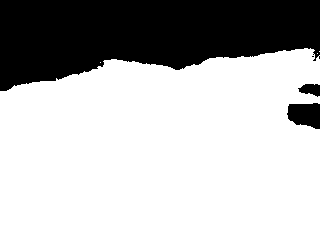

In [222]:
Image.fromarray((outputs.squeeze(0).argmax(0)*255).numpy().astype(np.uint8))

In [198]:
npim = cv2.resize((outputs.squeeze(0).argmax(0)*255).numpy().astype(np.uint8), (80,60))

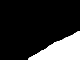

In [202]:
Image.fromarray(npim)

In [223]:
img = Image.open("/Users/karl/Downloads/1565732587156_watershed_mask.png")

In [224]:
img_np = np.asarray(img).astype(np.uint8)

In [226]:
cv2.imshow("img",img_np)

In [228]:
img_np

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [ 22,  22,  22],
        [ 22,  22,  22],
        ...,
        [ 22,  22,  22],
        [ 22,  22,  22],
        [255, 255, 255]],

       [[255, 255, 255],
        [ 22,  22,  22],
        [ 22,  22,  22],
        ...,
        [ 22,  22,  22],
        [ 22,  22,  22],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [  7,   7,   7],
        [  7,   7,   7],
        ...,
        [  7,   7,   7],
        [  7,   7,   7],
        [255, 255, 255]],

       [[255, 255, 255],
        [  7,   7,   7],
        [  7,   7,   7],
        ...,
        [  7,   7,   7],
        [  7,   7,   7],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]